In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time
from PIL import Image
from tqdm.notebook import tqdm as tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

In [3]:
!pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# all_models = torchvision.models.list_models()
# classification_models = torchvision.models.list_models(module=torchvision.models)
# classification_models

In [60]:
model = torch.hub.load("pytorch/vision", "efficientnet_v2_s", weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1")
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [61]:
model.classifier[1] = nn.Linear(1280, 2)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
import os

train_ad = os.listdir('/content/drive/MyDrive/vsosh/train/adults')
train_ch = os.listdir('/content/drive/MyDrive/vsosh/train/children')

test_ad = os.listdir('/content/drive/MyDrive/vsosh/test/adults')
test_ch = os.listdir('/content/drive/MyDrive/vsosh/test/children')

In [8]:
sum([x.numel()for x in model.parameters()])

20180050

In [9]:
import pandas as pd

In [10]:
df1 = pd.DataFrame({'img': train_ch, "label": 0}, columns = ['img', 'label'])
df1.img = "/content/drive/MyDrive/vsosh/train/children/" + df1.img

df2 = pd.DataFrame({'img': train_ad, "label": 1}, columns = ['img', 'label'])
df2.img = "/content/drive/MyDrive/vsosh/train/adults/" + df2.img

df_train = pd.concat([df1, df2])

In [11]:
df_train

,img,label
0,/content/drive/MyDrive/vsosh/train/children/10...,0
1,/content/drive/MyDrive/vsosh/train/children/10...,0
2,/content/drive/MyDrive/vsosh/train/children/10...,0
3,/content/drive/MyDrive/vsosh/train/children/10...,0
4,/content/drive/MyDrive/vsosh/train/children/10...,0
...,...,...
335,/content/drive/MyDrive/vsosh/train/adults/207.jpg,1
336,/content/drive/MyDrive/vsosh/train/adults/304.jpg,1
337,/content/drive/MyDrive/vsosh/train/adults/313.jpg,1
338,/content/drive/MyDrive/vsosh/train/adults/186.jpg,1


In [12]:
df1 = pd.DataFrame({'img': test_ch, "label": 0}, columns = ['img', 'label'])
df1.img = "/content/drive/MyDrive/vsosh/test/children/" + df1.img

df2 = pd.DataFrame({'img': test_ad, "label": 1}, columns = ['img', 'label'])
df2.img = "/content/drive/MyDrive/vsosh/test/adults/" + df2.img

ans_df = pd.concat([df1, df2])

In [13]:
resnet_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224), # размер каждой картинки будет приведен к 256*256
        # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # значения пикселей картинки нормализуются
    ])

In [14]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, data, transform=None, isTest = False):
        self.img_labels = data.label
        self.img_dir = data.img
        self.transform = transform
        self.isTest = isTest

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir.iloc[idx]
        image = read_image(img_path)

        label = self.img_labels.iloc[idx]

        if self.transform:
            image = self.transform(image)

        if self.isTest:
          return image.reshape((1, 3, 224, 224))


        return image, label

In [15]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_train, test_size=0.2 ,shuffle=True)

training_data = ImageDataset(data=df_train, transform=resnet_transforms)
valid_data = ImageDataset(data=df_test, transform=resnet_transforms)

In [16]:
BATCH_SIZE = 64

In [17]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE//2, shuffle=False)

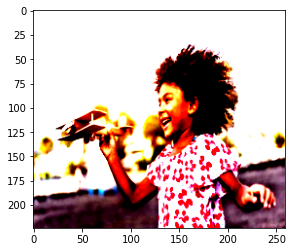

In [18]:
import matplotlib.pyplot as plt

plt.imshow(training_data[0][0].permute(1,2,0))

In [19]:
print(training_data[0][1])

0


In [20]:
# len(list(model.children()))

In [21]:
# for i, layer in enumerate(model.children()):
#   if i < 9:
#     for param in layer.parameters():
#       param.requires_grad = False

In [22]:
# for param in model.parameters():
#   print(param.requires_grad)

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [62]:
EPOCHS = 20
LEARNING_RATE = 0.001

In [63]:
model.to(device)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion =  torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.8, patience=50)


In [64]:
def train(dataloader, model, loss_fn, optimizer):
    epoch_loss = 0
    size = len(dataloader.dataset)
    model.train()
    for batch, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return loss/len(train_loader)


def test(dataloader, model):
    y_pred_list = []
    y_true_list = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            y_pred = torch.argmax(logits, dim=1)
            val_accuracy_per_epoch = np.mean(y_pred.cpu().numpy() == y_batch.cpu().numpy())

    return val_accuracy_per_epoch

In [27]:
# def train(model, learning_rate, loss_fn, n_epoch=3):

#     train_losses = []
#     val_accuracies = []
#     val_losses = []
    
#     # обучаем сеть
#     for epoch in tqdm_notebook(range(n_epoch)):

#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#         train_dataiter = iter(train_loader)
#         running_loss = 0.0

#         model.train(True)
#         for i, batch in enumerate(tqdm_notebook(train_dataiter)):
#             X_batch, y_batch = batch # так получаем текущий батч
#             X_batch = X_batch.to(device)
#             y_batch = y_batch.to(device)
            
#             logits = model(X_batch) # forward pass (получение ответов на батч картинок)
#             loss = loss_fn(logits, y_batch) # вычисление лосса от выданных сетью ответов и правильных ответов на батч
#             loss.backward() # backpropagation (вычисление градиентов)
#             optimizer.step() # обновление весов сети
#             optimizer.zero_grad() # обнуляем веса
#             # выведем текущий loss
#             running_loss += loss.item()

#             # выведем лосс каждые 50 батчей
#             if i % 5 == 4:
#                 print('[%d, %5d] loss: %.3f' %
#                     (epoch + 1, i + 1, running_loss / 4))
#                 train_losses.append(running_loss / 4)
#                 running_loss = 0.0

#         # evaluate on val
#         model.train(False)
#         val_dataiter = iter(val_loader)
#         torch.save(model.state_dict(), '/content/drive/MyDrive/vsosh/checkpoint.pth')


#         val_loss_per_epoch = 0
#         val_accuracy_per_epoch = 0
#         for i, batch in enumerate(tqdm_notebook(val_dataiter)):
#             # так получаем текущий батч
#             X_batch, y_batch = batch
#             X_batch = X_batch.to(device)
#             y_batch = y_batch.to(device)
#             with torch.no_grad():
#                 logits = model(X_batch)
#                 y_pred = torch.argmax(logits, dim=1)
#                 val_accuracy_per_epoch += np.mean(y_pred.cpu().numpy() == y_batch.cpu().numpy())

#                 val_loss_per_epoch += loss_fn(logits, y_batch)

#         val_accuracies.append(val_accuracy_per_epoch / (i + 1))
#         val_losses.append(val_loss_per_epoch / (i + 1))
#         print(f"Accuracy is : {val_accuracy_per_epoch / (i + 1)}")

#     print('Обучение закончено')
#     return model, train_losses, val_losses, val_accuracies

In [28]:
# model, train_losses, val_losses, val_accuracies = train(model, learning_rate, loss_fn, n_epoch=1)

In [80]:
epochs = EPOCHS
best_loss = 100
best_acc = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_loss = train(train_loader, model, criterion, optimizer)
    avg_acc = test(test_loader, model)
    print(f"Test Error: \n Accuracy: {(avg_acc):>0.3f}%, Avg loss: {avg_loss:>8f} \n")
    if best_acc < avg_acc:
      torch.save(model.state_dict(), "best.pth")
      best_acc = avg_acc
      print("New best checkpoint saved")

    # elif best_acc == avg_acc and best_loss > avg_loss:
    #     best_loss = avg_loss
    #     torch.save(model.state_dict(), "best.pth")
    #     print("New best checkpoint saved")
      
    lr = optimizer.param_groups[0]["lr"]
    print(f"learning rate: {lr}")
    scheduler.step(avg_acc)
    

print("\nDone!")
print(f"Best accuracy is {best_acc}!")

Epoch 1
-------------------------------


KeyboardInterrupt: ignored

In [30]:
# test = os.listdir('/content/drive/MyDrive/vsosh/test')
# ans_df = pd.DataFrame({'filename': test, "label": 0}, columns = ['filename', 'label'])
# ans_df_for_pt = pd.DataFrame({'img': test, "label": 0}, columns = ['img', 'label'])
# ans_df_for_pt.img = "/content/drive/MyDrive/vsosh/test/" + ans_df_for_pt.img

In [74]:
del model
model = torch.hub.load("pytorch/vision", "efficientnet_v2_s", weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1")
model.classifier[1] = nn.Linear(1280, 2)
model.to(device)

model.load_state_dict(torch.load('/content/best.pth'))

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


<All keys matched successfully>

In [75]:
ans_data = ImageDataset(data=ans_df, transform=resnet_transforms, isTest=False)
ans_loader = torch.utils.data.DataLoader(ans_data, batch_size=256, shuffle=False)

In [76]:
len(ans_data)

120

In [77]:
ans_arr = []
y_arr = []

In [78]:
 for i, batch in enumerate(tqdm_notebook(iter(ans_loader))):
            X_batch, y_batch = batch # так получаем текущий батч
            X_batch = X_batch.to(device)
            with torch.no_grad():
                logits = model(X_batch)
                y_pred = torch.argmax(logits, dim=1)
                ans_arr.append(y_pred)
                y_arr.append(y_batch.cpu().detach())


  0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
np.mean(ans_arr[0].cpu().detach().numpy() == y_arr[0].numpy())

0.8166666666666667

In [ ]:
for i in range(len(ans_arr)):
  ans_arr[i] = ans_arr[i].cpu()

In [ ]:
for i in range(len(ans_arr)):
  ans_arr[i] = ans_arr[i][0].item()

In [ ]:
test = os.listdir('/content/drive/MyDrive/vsosh/test')
ans_df = pd.DataFrame({'filename': test, "label": ans_arr}, columns = ['filename', 'label'])

In [ ]:
ans_df.to_csv('/content/drive/MyDrive/vsosh/eleventh.csv', index=False)